In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset as TorchDataset
import torch
import torch.nn.functional as F
from torchvision.transforms import Compose
import matplotlib.pyplot as plt

In [3]:
image_dir = 'archive/images/train'
label_dir = 'archive/labels/train'
test_dir = 'archive/images/test'

print("Images Directory:", os.listdir(image_dir))

print("Labels Directory:", os.listdir(label_dir))

print("Test Directory:", os.listdir(test_dir))

Images Directory: ['aachen', 'bochum', 'bremen', 'cologne', 'darmstadt', 'dusseldorf', 'erfurt', 'hamburg', 'hanover', 'jena', 'krefeld', 'monchengladbach', 'strasbourg', 'stuttgart', 'tubingen', 'ulm', 'weimar', 'zurich']
Labels Directory: ['aachen', 'bochum', 'bremen', 'cologne', 'darmstadt', 'dusseldorf', 'erfurt', 'hamburg', 'hanover', 'jena', 'krefeld', 'monchengladbach', 'strasbourg', 'stuttgart', 'tubingen', 'ulm', 'weimar', 'zurich']
Test Directory: ['aachen', 'bochum', 'bremen', 'cologne', 'darmstadt', 'dusseldorf', 'erfurt', 'hamburg', 'hanover', 'jena', 'krefeld', 'monchengladbach', 'strasbourg', 'stuttgart', 'tubingen', 'ulm', 'weimar', 'zurich']


In [4]:
# Function to generate file paths for train dataset
def get_train_file_paths(image_dir, label_dir):
    data = []
    # Iterate through cities in the train images folder
    for city in os.listdir(image_dir):
        city_image_dir = os.path.join(image_dir, city)
        city_label_dir = os.path.join(label_dir, city)
        if os.path.isdir(city_image_dir) and os.path.isdir(city_label_dir):
            for file in os.listdir(city_image_dir):
                if file.endswith('_leftImg8bit.png'):
                    image_path = os.path.join(city_image_dir, file)
                    image_name = file.replace('_leftImg8bit.png', '')
                    image_label_path = os.path.join(city_label_dir, f'{image_name}_gtFine_labelTrainIds.png')
                    image_polygons_path = os.path.join(city_label_dir, f'{image_name}_gtFine_polygons.json')
                    data.append([image_path, image_label_path, image_polygons_path])
    return pd.DataFrame(data, columns=['image_path', 'image_label_path', 'image_polygons_path'])

# Function to generate file paths for test dataset
def get_test_file_paths(test_dir):
    data = []
    # Iterate through cities in the test images folder
    for city in os.listdir(test_dir):
        city_dir = os.path.join(test_dir, city)
        if os.path.isdir(city_dir):
            for file in os.listdir(city_dir):
                if file.endswith('_leftImg8bit.png'):
                    image_path = os.path.join(city_dir, file)
                    data.append([image_path])
    return pd.DataFrame(data, columns=['image_path'])

# Create train and test DataFrames
train_df = get_train_file_paths(image_dir, label_dir)
test_df = get_test_file_paths(test_dir)

In [5]:
print("Number of Samples before Split: ", len(train_df))

# Shuffle the DataFrame
train_df = train_df.sample(frac=1).reset_index(drop=True)

# Calculate the number of samples for the validation set
val_size = 380

# Split the DataFrame into train and validation sets
train_df_final = train_df[:-val_size]
val_df_final = train_df[-val_size:]

print("Train Samples (After Split): ", len(train_df_final))
print("Val Samples (After Split): ", len(val_df_final))

#TODO : Save the split to csv file
val_df_final.to_csv("val_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)

Number of Samples before Split:  2380
Train Samples (After Split):  2000
Val Samples (After Split):  380


In [6]:
print("Number of Samples before Split: ", len(train_df_final))

train_df_one = train_df_final[:300]  
# train_df_two = train_df_final[300:600]  
# train_df_three = train_df_final[600:900]  
# train_df_four = train_df_final[900:1200]  
# train_df_five = train_df_final[1200:1500]
# train_df_six = train_df_final[1500:1800]  
# train_df_seven = train_df_final[1800:2000]  

print("Train Samples one: ", len(train_df_one))
# print("Train Samples two: ", len(train_df_two))
# print("Train Samples three: ", len(train_df_three))
# print("Train Samples four: ", len(train_df_four))
# print("Train Samples five: ", len(train_df_five))
# print("Train Samples six: ", len(train_df_six))
# print("Train Samples seven: ", len(train_df_seven))



#TODO : Save the split to csv file
train_df_one.to_csv("train_one.csv", index=False)
# train_df_two.to_csv("train_two.csv", index=False)
# train_df_three.to_csv("train_three.csv", index=False)
# train_df_four.to_csv("train_four.csv", index=False)
# train_df_five.to_csv("train_four.csv", index=False)
# train_df_six.to_csv("train_four.csv", index=False)
# train_df_seven.to_csv("train_four.csv", index=False)

Number of Samples before Split:  2000
Train Samples one:  300


In [7]:
train_data_one = pd.read_csv('train_one.csv')

In [8]:
# Define the LoadImage transformation
class LoadImage:
    def __init__(self, keys):
        self.keys = keys

    def __call__(self, sample):
        for key in self.keys:
            sample[key] = cv2.imread(sample[key])
        return sample

In [9]:
# Define the Normalize transformation
class Normalize:
    def __call__(self, sample):
        sample['image'] = sample['image'] / 255.0  # Normalize to [0, 1]
        return sample

In [10]:
class ContrastMask:
    def __init__(self, keys):
        self.keys = keys

    def enhance_contrast(self, mask):
        # Convert to float to avoid clipping during operations
        mask_float = mask.astype(np.float32)
        # Apply histogram equalization
        mask_equalized = cv2.equalizeHist(mask_float.astype(np.uint8))
        return mask_equalized

    def __call__(self, sample):
        for key in self.keys:
            if key == 'mask':
                # Convert mask to grayscale if it's not already
                if len(sample[key].shape) == 3:
                    sample[key] = cv2.cvtColor(sample[key], cv2.COLOR_BGR2GRAY)
                sample[key] = self.enhance_contrast(sample[key])
        return sample

In [11]:
# # colored mask
# mask_colored = cv2.applyColorMap(mask_enhanced, cv2.COLORMAP_JET)

# # Visualize the colored mask
# plt.figure(figsize=(6, 6))
# plt.title('Colored Enhanced Mask')
# plt.imshow(mask_colored)
# plt.axis('off')
# plt.show()

In [12]:
# Define the Resize transformation
class Resize:
    def __init__(self, size):
        self.size = size

    def __call__(self, sample):
        for key in sample.keys():
            sample[key] = cv2.resize(sample[key], self.size)
        return sample

In [13]:
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, sample):
        for transform in self.transforms:
            sample = transform(sample)
        return sample

In [14]:
# Define the training data transform pipeline
Train_data_transform = Compose([
    LoadImage(keys=['image', 'mask']),
    Resize(size=(256, 256)),
    Normalize(),
    ContrastMask(keys=['mask'])
])

In [15]:
# Preprocess training data
def preprocess_data(df):
    processed_data = []
    for index, row in df.iterrows():
        sample = {'image': row['image_path'], 'mask': row['image_label_path']}
        transformed_sample = Train_data_transform(sample)
        processed_data.append((transformed_sample['image'], transformed_sample['mask']))
    return processed_data

In [16]:
# Preprocess training data
processed_data = preprocess_data(train_data_one)
print(f"Processed Images: {len(processed_data)}")

Processed Images: 300


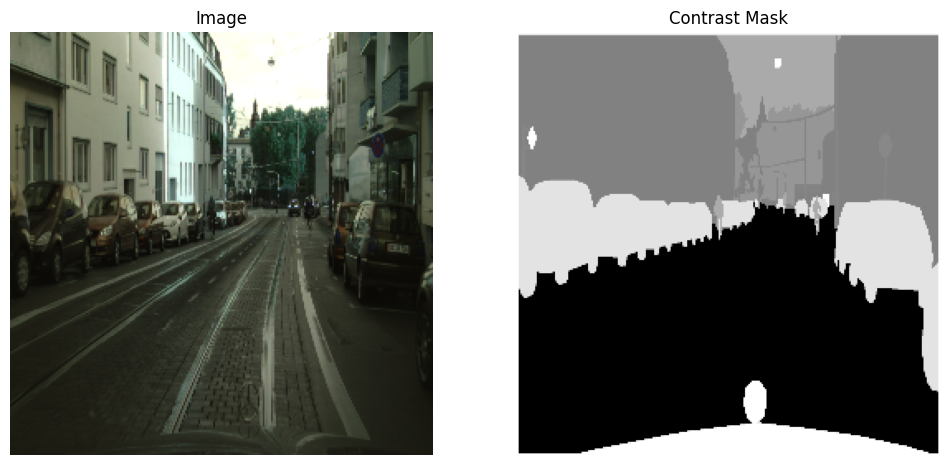

In [17]:
# visualize a sample
def visualize_sample(processed_sample):
    image, mask = processed_sample
    # Convert image from [0, 1] to [0, 255] for display
    image = (image * 255).astype(np.uint8)

    # Create a figure to show image and mask
    plt.figure(figsize=(12, 6))

    # Display the image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')

    # Display the mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Contrast Mask')
    plt.axis('off')

    plt.show()

visualize_sample(processed_data[299])

In [18]:
Val_data_transform = Compose([
    LoadImage(keys=['image', 'mask']),
    Resize(size=(256, 256)),
    Normalize(),
    ContrastMask(keys='mask'),
])

In [19]:
# Preprocess val data
def preprocess_val_data(df):
    processed_val_data = []
    for index, row in df.iterrows():
        sample = {'image': row['image_path'], 'mask': row['image_label_path']}
        transformed_sample = Val_data_transform(sample)
        processed_val_data.append((transformed_sample['image'], transformed_sample['mask']))
    return processed_val_data

In [20]:
# Preprocess validation data
processed_val_data = preprocess_data(val_df_final)
# Example output to verify shapes
print(f"Processed Images: {len(processed_val_data)}")

Processed Images: 380


In [21]:
test_data_transform = Compose([
    LoadImage(keys=['image']),
    Resize(size=(256, 256)),
    Normalize(),
])

In [22]:
# Preprocess testing data
def preprocess_test_data(df):
    processed_test_data = []
    for index, row in df.iterrows():
        sample = {'image': row['image_path']}
        transformed_sample = test_data_transform(sample)
        processed_test_data.append((transformed_sample['image']))
    return processed_test_data

In [23]:
# Preprocess validation data
processed_test_data = preprocess_test_data(test_df)
# Example output to verify shapes
print(f"Processed Images: {len(processed_test_data)}")

Processed Images: 595


In [24]:
processed_data

[(array([[[0.34117647, 0.38039216, 0.33333333],
          [0.16862745, 0.20784314, 0.14901961],
          [0.11372549, 0.14509804, 0.1254902 ],
          ...,
          [0.10588235, 0.2       , 0.16078431],
          [0.15294118, 0.23529412, 0.28627451],
          [0.09803922, 0.19607843, 0.10980392]],
  
         [[0.36470588, 0.40392157, 0.35686275],
          [0.18039216, 0.22352941, 0.15686275],
          [0.11372549, 0.14509804, 0.12941176],
          ...,
          [0.13333333, 0.22352941, 0.18823529],
          [0.16470588, 0.24705882, 0.28235294],
          [0.1254902 , 0.21568627, 0.14509804]],
  
         [[0.34901961, 0.40392157, 0.36470588],
          [0.20784314, 0.24705882, 0.17647059],
          [0.11372549, 0.14901961, 0.12941176],
          ...,
          [0.15686275, 0.24313725, 0.21568627],
          [0.17647059, 0.25490196, 0.27843137],
          [0.14901961, 0.23529412, 0.18039216]],
  
         ...,
  
         [[0.17647059, 0.21568627, 0.18039216],
          [0.1

In [25]:
print(os.listdir('processed_images'))

['image_0.png', 'image_1.png', 'image_10.png', 'image_100.png', 'image_101.png', 'image_102.png', 'image_103.png', 'image_104.png', 'image_105.png', 'image_106.png', 'image_107.png', 'image_108.png', 'image_109.png', 'image_11.png', 'image_110.png', 'image_111.png', 'image_112.png', 'image_113.png', 'image_114.png', 'image_115.png', 'image_116.png', 'image_117.png', 'image_118.png', 'image_119.png', 'image_12.png', 'image_120.png', 'image_121.png', 'image_122.png', 'image_123.png', 'image_124.png', 'image_125.png', 'image_126.png', 'image_127.png', 'image_128.png', 'image_129.png', 'image_13.png', 'image_130.png', 'image_131.png', 'image_132.png', 'image_133.png', 'image_134.png', 'image_135.png', 'image_136.png', 'image_137.png', 'image_138.png', 'image_139.png', 'image_14.png', 'image_140.png', 'image_141.png', 'image_142.png', 'image_143.png', 'image_144.png', 'image_145.png', 'image_146.png', 'image_147.png', 'image_148.png', 'image_149.png', 'image_15.png', 'image_150.png', 'image

In [26]:
os.makedirs('processed_images', exist_ok=True)
os.makedirs('processed_masks', exist_ok=True)


In [27]:
def save_processed_data(processed_data, output_dir_images, output_dir_masks):
    os.makedirs(output_dir_images, exist_ok=True)
    os.makedirs(output_dir_masks, exist_ok=True)

    for idx, (image, mask) in enumerate(processed_data):
        cv2.imwrite(os.path.join(output_dir_images, f'image_{idx}.png'), image)
        cv2.imwrite(os.path.join(output_dir_masks, f'mask_{idx}.png'), mask)

# Call the function to save images and masks
save_processed_data(processed_data, 'processed_images', 'processed_masks')

In [28]:
os.makedirs('processed_val_images', exist_ok=True)
os.makedirs('processed__val_masks', exist_ok=True)

In [29]:
def save_processed_data(processed_data, output_dir_images, output_dir_masks):
    os.makedirs(output_dir_images, exist_ok=True)
    os.makedirs(output_dir_masks, exist_ok=True)

    for idx, (image, mask) in enumerate(processed_val_data):
        cv2.imwrite(os.path.join(output_dir_images, f'image_{idx}.png'), image)
        cv2.imwrite(os.path.join(output_dir_masks, f'mask_{idx}.png'), mask)

# Call the function to save images and masks
save_processed_data(processed_val_data, 'processed_val_images', 'processed__val_masks')

In [30]:
os.makedirs('processed_test_images', exist_ok=True)

In [31]:
def save_processed_data(processed_data, output_dir_images):
    os.makedirs(output_dir_images, exist_ok=True)

    for idx, (image) in enumerate(processed_test_data):
        cv2.imwrite(os.path.join(output_dir_images, f'image_{idx}.png'), image)

# Call the function to save images and masks
save_processed_data(processed_test_data, 'processed_test_images')